In [1]:
using NBInclude

@nbinclude("julia_function.ipynb")

allskyts2 (generic function with 1 method)

In [2]:
# Defining oscillation probability function with distinct mass splitting values

function oscprobdistinct(et, dm21, dm22, dm23, leff)

    u = @SMatrix [0.674743 0.302844 0.0224125;
                  0.0946105 0.360415 0.544974;
                  0.230646 0.33674 0.432613]

    # Conversion factor to go from kpc to 1/eV
    convfactor = 3.086e19 * 5.06773093741 * 1e6

    leff *= convfactor

    osc1 = (cos((dm21 * leff)/(4*et*1e12)))^2
    osc2 = (cos((dm22 * leff)/(4*et*1e12)))^2
    osc3 = (cos((dm23 * leff)/(4*et*1e12)))^2

    prob_surv = osc1*(u[1]*u[1]) + osc2*(u[4]*u[4]) + osc3*(u[7]*u[7])
    prob_mue = osc1*(u[1]*u[2]) + osc2*(u[4]*u[5]) + osc3*(u[7]*u[8])
    prob_e = 0.666666*prob_mue + 0.333333*prob_surv 
end

oscprobdistinct (generic function with 1 method)

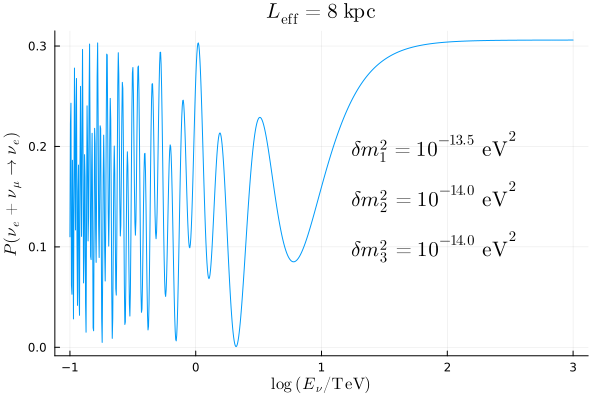

In [80]:
# Plotting the new oscillation probabilities

dm2s = (10^(-13.5), 10^(-14), 10^(-14))

leff = 8

us = range(-1, 3, 1000)
es = 10 .^ us

oscprobs = oscprobdistinct.(es, dm2s[1], dm2s[2], dm2s[3], leff)

plot(
    us,
    oscprobs,
    xlabel=L"\log~(E_{\nu} / \mathrm{TeV})",
    ylabel=L"P(\nu_{e} + \nu_{\mu} \to \nu_{e})",
    ann=[(1.9, 0.2, L"\delta m_1^2 = 10^{-13.5}~\mathrm{eV}^2"), (1.9, 0.15, L"\delta m_2^2 = 10^{-14.0}~\mathrm{eV}^2"), (1.9, 0.1, L"\delta m_3^2 = 10^{-14.0}~\mathrm{eV}^2")],
    label=false,
    title=L"L_{\mathrm{eff}} = 8~\mathrm{kpc}"
)

In [4]:
# Redefining event distribution functions

function smearedeventdistdistinct(dm21, dm22, dm23, l, b, σ, ϕ₀, γ, θ, nsteps)
    
    function f(ur)
        et = 10^ur
        r0, rmax = 0, 30
        blength = 0.5
        rbins = range(r0, stop=rmax, step=blength)

        # vols = @. blength * pi * (rbins * tan(θ)) ^ 2
        vols = blength .* sbinarea.(rbins, l, b, θ) .* oscprobdistinct.(et, dm21, dm22, dm23, rbins)

        flx = fluxfreeparams(et, cartx.(rbins, l, b), carty.(rbins, l, b), cartz.(rbins, l, b), ϕ₀, γ)
        effa = effarea(et)[1]*10000

        sum(.*(flx, vols, effa))
    end

    samples = range(-0.5, log10(emax)+0.5, length=300)
    de = samples[2]-samples[1]

    pdf_func(ur) = log(10) * exp10.(ur .- 0) * pdf(Normal(0, σ), abs(1 - exp10(ur - 0)))
    gsample = pdf_func.(samples)
    g_fft = fft(gsample)

    fsample = f.(samples)
    f_fft = fft(fsample)
    C = f_fft .* g_fft
    c = real(ifft(C)) .* de
    
    # Translation factor
    # samples1 = samples .+ 0.5
    
    cut = trunc(Int, (0.5)/de)
    c1 = vcat(c[(cut+1):end], zeros(cut))
    
    fg = interpolate((samples,), c1, Gridded(Linear()))

    loges = range(log10(emin), log10(emax), nsteps)
    output = fg.(loges)
end

function edistbinneddistinct(dm21, dm22, dm23, l, b, σ, θ, ϕ₀, γ)
    emin = 0.7916819159263001
    emax = 791.6819159263017
    nbins = 50
    nsteps = 1000
    us = range(log10(emin), log10(emax), nsteps)    
    du = us[2] - us[1]
    steps = smearedeventdistdistinct(dm21, dm22, dm23, l, b, σ, ϕ₀, γ, θ, nsteps) .* du .* (10 .^ us) .* log(10)
    matrix = reshape(steps, (20, :)) # This 2 is the ratio nsteps/nbins
    sums = sum(matrix, dims=1)
    νbins = vec(sums)
end

edistbinneddistinct (generic function with 1 method)

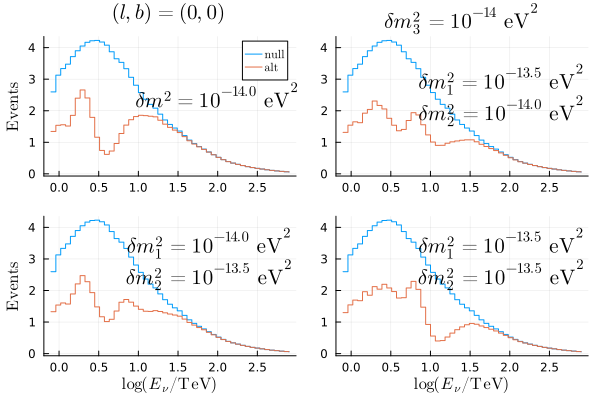

In [5]:
# Plotting the new event distributions

dm2s = (10^(-14), 10^(-14), 10^(-14))
dm2s1 = (10^(-13.5), 10^(-14), 10^(-14))
dm2s2 = (10^(-14), 10^(-13.5), 10^(-14))
dm2s3 = (10^(-13.5), 10^(-13.5), 10^(-14))

ubins = range(log10(emin), log10(emax), length=50)

distbins = edistbinneddistinct(dm2s[1], dm2s[2], dm2s[3], 0, 0, 0.01, 0.122, 21.8, 2.7)
distbins1 = edistbinneddistinct(dm2s1[1], dm2s1[2], dm2s1[3], 0, 0, 0.01, 0.122, 21.8, 2.7)
distbins2 = edistbinneddistinct(dm2s2[1], dm2s2[2], dm2s2[3], 0, 0, 0.01, 0.122, 21.8, 2.7)
distbins3 = edistbinneddistinct(dm2s3[1], dm2s3[2], dm2s3[3], 0, 0, 0.01, 0.122, 21.8, 2.7)


distbinsnull = edistbinneddistinct(0.0, 0.0, 0.0, 0, 0, 0.01, 0.122, 21.8, 2.7)

p0 = plot(
    ubins,
    [distbinsnull distbins],
    seriestype=:step,
    # xlabel=L"\log (E_{\nu} / \mathrm{TeV})",
    ylabel=L"\mathrm{Events}",
    label=[L"\mathrm{null}" L"\mathrm{alt}"],
    title=L"(l, b) = (0, 0)",
    ann=[(2, 2.5, L"\delta m^2 = 10^{-14.0}~\mathrm{eV}^2")]
)

p1 = plot(
    ubins,
    [distbinsnull distbins1],
    seriestype=:step,
    # xlabel=L"\log (E_{\nu} / \mathrm{TeV})",
    # ylabel=L"\mathrm{Events}",
    # label=[L"\mathrm{null}" L"\mathrm{alt}"],
    label=false,
    title=L"\delta m_3^2 = 10^{-14}~\mathrm{eV}^2",
    ann=[(1.9, 3, L"\delta m_1^2 = 10^{-13.5}~\mathrm{eV}^2"), (1.9, 2, L"\delta m_2^2 = 10^{-14.0}~\mathrm{eV}^2")]
)

p2 = plot(
    ubins,
    [distbinsnull distbins2],
    seriestype=:step,
    xlabel=L"\log (E_{\nu} / \mathrm{TeV})",
    ylabel=L"\mathrm{Events}",
    # label=[L"\mathrm{null}" L"\mathrm{alt}"],
    label=false,
    # title=L"\delta m_3^2 = 10^{-14}~\mathrm{eV}^2",
    ann=[(1.9, 3.5, L"\delta m_1^2 = 10^{-14.0}~\mathrm{eV}^2"), (1.9, 2.5, L"\delta m_2^2 = 10^{-13.5}~\mathrm{eV}^2")]
)

p3 = plot(
    ubins,
    [distbinsnull distbins3],
    seriestype=:step,
    xlabel=L"\log (E_{\nu} / \mathrm{TeV})",
    # ylabel=L"\mathrm{Events}",
    # label=[L"\mathrm{null}" L"\mathrm{alt}"],
    label=false,
    # title=L"\delta m_2^2 = \delta m_3^2 = 10^{-14}~\mathrm{eV}^2",
    ann=[(1.9, 3.5, L"\delta m_1^2 = 10^{-13.5}~\mathrm{eV}^2"), (1.9, 2.5, L"\delta m_2^2 = 10^{-13.5}~\mathrm{eV}^2")]
)

plot(p0, p1, p2, p3, layout=(2, 2))

In [65]:
# Redefined the likelihood functions

function negloglhdistinct(dm21, dm22, dm23, l, b, θ, ϕ₀, γ, σ)

    nullhyp = edistbinneddistinct(0, 0, 0, l, b, σ, θ, 21.8, 2.7)
    althyp = edistbinneddistinct(dm21, dm22, dm23, l, b, σ, θ, ϕ₀, γ)

    altsummand = poissonlog.(nullhyp, althyp)

    nloglh = -sum(altsummand)
end


function maxlhdistinct(dm21, dm22, dm23, l, b)

    θ = 0.122
    σ = 0.01

    function nllh(test)
        return negloglhdistinct(dm21, dm22, dm23, l, b, θ, test[1], test[2], σ)
    end

    x0 = [21.8, 2.7]

    optimize(nllh, x0, NelderMead())
end

function lrtbinneddistinct(dm21, dm22, dm23, l, b)
    minim = maxlhdistinct(dm21, dm22, dm23, l, b)

    params = Optim.minimizer(minim)

    null = edistbinneddistinct(0, 0, 0, l, b, 0.5, 0.122, 21.8, 2.7)
    alt = edistbinneddistinct(dm21, dm22, dm23, l, b, 0.5, 0.122, params[1], params[2])

    ts = lrt(null, alt)
end

lrtbinneddistinct (generic function with 1 method)

In [66]:
# Calculating sensitivities for different distinct mass splittings

logdm21s = range(-15, -13, 40)
logdm22s = range(-15, -13, 40)

dm21s = 10 .^ logdm21s
dm22s = 10 .^ logdm22s
dm23 = 10^(-14)

teststatsdistinct = [lrtbinneddistinct(dm21, dm22, dm23, 0, 0) for dm22 in dm22s, dm21 in dm21s]


40×40 Matrix{Float64}:
 0.305496  0.42084   0.584324  0.811958  …  0.590723  0.543374  0.496672
 0.363857  0.492397  0.673299  0.923892     0.600404  0.557379  0.51455
 0.438929  0.583731  0.78633   1.06555      0.622512  0.584668  0.546448
 0.533405  0.698019  0.926994  1.24141      0.662248  0.630448  0.597653
 0.648122  0.836005  1.09623   1.45266      0.723962  0.699175  0.672593
 0.77932   0.993267  1.28875   1.69289   …  0.80825   0.791179  0.771458
 0.915153  1.15577   1.48768   1.94187      0.906556  0.897804  0.885429
 1.03283   1.29668   1.66092   2.16014      0.996633  0.99617   0.991183
 1.10071   1.37842   1.76254   2.2906       1.04428   1.05141   1.05321
 1.0895    1.36549   1.74864   2.27764      1.02083   1.03386   1.04112
 0.991951  1.24747   1.60481   2.10106   …  0.932603  0.949026  0.959561
 0.834614  1.05416   1.36463   1.80021      0.83342   0.850121  0.861369
 0.666197  0.842091  1.09576   1.45762      0.789641  0.803726  0.813197
 ⋮                             

In [73]:
# Saving the array

# writedlm("misc_data/distinct_dm2_vals_005_res.txt", teststatsdistinct)

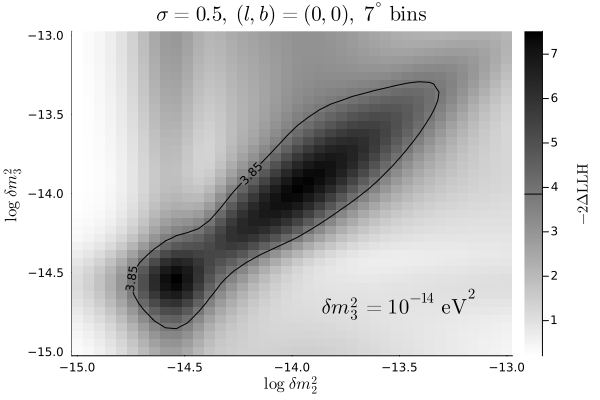

In [76]:
# Plotting the data

plot(
    logdm21s,
    logdm22s,
    teststatsdistinct,
    c=:grayC,
    xlabel=L"\log~\delta m_2^2",
    ylabel=L"\log~\delta m_3^2",
    colorbar_title=L"-2\Delta\mathrm{LLH}",
    title=L"\sigma = 0.5,~(l, b) = (0, 0),~7^{\circ}~\mathrm{bins}",
    ann=[(-13.5, -14.7, L"\delta m_3^2 = 10^{-14}~\mathrm{eV}^2")],
    seriestype=:heatmap,
    # interpolate=true
)

plot!(
    logdm21s,
    logdm22s,
    teststatsdistinct,
    levels=[3.85],
    c=:black,
    clabels=true
)

In [72]:
# Saving the plot

# savefig("misc_plots/distinct_dm2_vals_005_res.png")

"/Users/millermacdonald/Desktop/Research_shit/Summer_2023_Research/GC_calcs/misc_plots/distinct_dm2_vals_005_res.png"